In [31]:
import os
import json
from google.cloud import storage
from tempfile import TemporaryFile

In [35]:
# gcloud settings
key_path = '../credentials/gs-access-key.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path
BUCKET = 'deep-musik-data'
JOB = 'trainer/config0/200623_124035'
client = storage.Client()
bucket = client.bucket(BUCKET)

### Load data

In [36]:
# Load training data config used for the training job
config_blob = bucket.blob(f'output/{JOB}/data_config.json')
with TemporaryFile() as tmp:
    config_blob.download_to_file(tmp)
    tmp.seek(0)
    train_config = json.load(tmp)
train_config

{'data_id': 0, 'instruments': ['keyboard_acoustic', 'guitar_acoustic']}

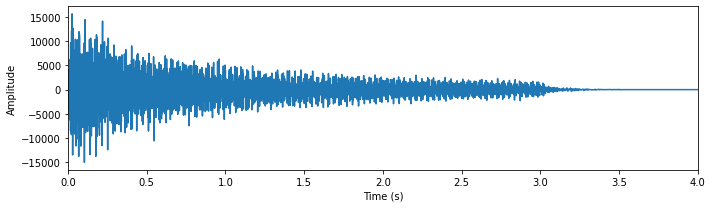

In [86]:
from audiolib import AudioDataset

ads = AudioDataset('../data/raw/nsynth-test/')
af = ads.load_file(instrument='keyboard_electronic', file_index=0)
af.audio.plot()
af.audio.play()

### Preprocessing

In [87]:
# Load preprocessing config associated with the training data config
with open('../src/preprocessing/shell/configs.json') as f:
    data_configs = json.load(f)
data_config = data_configs[train_config['data_id']]['config']
data_config

{'start': 0.2,
 'end': 3,
 'time_intervals': 1,
 'resolution': 5,
 'exclude': ['fast_decay']}

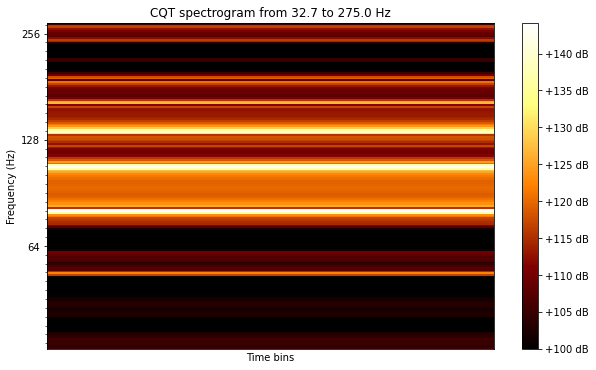

In [88]:
# Convert audio to spectrogram
from preprocessing.preprocess import audio_to_spectrogram

spec = audio_to_spectrogram(af.audio, data_config)
spec.plot(db_thresh=100)

In [89]:
# Load the normalisation parameters used for the training data
norm_blob = bucket.blob(f'output/{JOB}/norm_params.json')
with TemporaryFile() as tmp:
    norm_blob.download_to_file(tmp)
    tmp.seek(0)
    norm_params = json.load(tmp)
norm_params

{'mean': 508844.78034905693, 'std': 3067823.5106150364}

In [90]:
import numpy as np
from trainer.dataset import ToTensor, Normalise

norm = Normalise(norm_params['mean'], norm_params['std'])
tensor = ToTensor(float32=True)

spec_norm = tensor(norm(np.abs(spec).reshape(1, 1, -1)))

### Model scoring

In [91]:
import torch
from trainer.model import MusicNet

# Download model from gcloud
model_blob = bucket.blob(f'output/{JOB}/model.pt')
with TemporaryFile() as tmp:
    model_blob.download_to_file(tmp)
    tmp.seek(0)
    state_dict = torch.load(tmp)

# Create model with state_dict weights
model = MusicNet()
model.load_state_dict(state_dict)
model

MusicNet(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=3712, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [92]:
# Predictions
with torch.no_grad():
    label_proba = torch.exp(model.forward(spec_norm))
    label_numeric = torch.argmax(label_proba)
    label = train_config['instruments'][label_numeric]
    print(f'{label} ({100*torch.max(label_proba).numpy():.2f} %)')

keyboard_acoustic (100.00 %)
